# **Analysis of the effect of Query Set Size on the performance of Submodular methods used to solve Cold Start Problem with SMS Spam Dataset**

# Setup

## Get Distil and Submodlib from Decile Repo

In [ ]:
# Get DISTIL
!git clone https://github.com/decile-team/distil.git

# Get submodlib
!git clone https://github.com/decile-team/submodlib.git

Cloning into 'distil'...
remote: Enumerating objects: 3498, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 3498 (delta 302), reused 336 (delta 279), pack-reused 3045
Receiving objects: 100% (3498/3498), 23.10 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (2246/2246), done.
Cloning into 'submodlib'...
remote: Enumerating objects: 2570, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 2570 (delta 2), reused 0 (delta 0), pack-reused 2559
Receiving objects: 100% (2570/2570), 30.57 MiB | 12.25 MiB/s, done.
Resolving deltas: 100% (1911/1911), done.
Updating files: 100% (307/307), done.


## Installations

#### *Restart runtime from here after initial install is complete*

In [ ]:
# Installations for DISTIL
!cd distil && pip install -r distil/requirements/requirements.txt
!pip install -r distil/requirements/requirements.txt

# Required installations
!pip install transformers
!pip install datasets

# Installations for Submodlib
!pip install -e ./submodlib/

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'distil/requirements/requirements.txt'
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
  Using cached sphinxcontrib_bibtex-2.6.1-py3-none-any.whl (40 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached scikit-learn-0.23.0.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Obtaining file:///content/submodlib
  Installing build dependencies ... done
  Checking if build

## Imports

In [ ]:
# Standard imports
import copy
import html
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import random # Import for query size sampling
import re # Import for baseline regex matching
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import statistics as stat
import string
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import unicodedata

# Imports for datasets
from collections import Counter
from datasets import Dataset as D
from datasets import load_dataset, load_metric, concatenate_datasets
from io import BytesIO
import requests
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, ConcatDataset
from tqdm.auto import tqdm
import zipfile

# Additional Imports
from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

# Imports for active learning
sys.path.append('submodlib/')
sys.path.append('distil/')
from distil.active_learning_strategies import BADGE, SMI, EntropySampling, LeastConfidenceSampling, MarginSampling, RandomSampling   # All active learning strategies showcased in this example
from distil.utils.utils import LabeledToUnlabeledDataset # A utility wrapper class that removes labels from labeled PyTorch dataset objects

## Download GloVe vectorizer

In [ ]:
# Get a simple tokenizer from torchtext. Use GloVe embeddings from torchtext, which will automatically download them.
glove_tokenizer     = get_tokenizer("basic_english")
glove_vectorizer    = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [01:09<00:00, 5726.78it/s]


The above procedure should take 15-30 minutes. The rest of the code should run quicker.

# Data loading, sampling and pre-processing

## Load data from UCI_ML/Github Repository

In [ ]:
# URL of the CSV file containing the SMS Spam Collection dataset
sms_url = 'https://raw.github.com/ayushbits/robust-aggregate-lfs/main/reef/data/sms/all.csv'

# Load the data, skipping bad lines
sms_df = pd.read_csv(sms_url, on_bad_lines='skip')

# Display SMS dataframe data
sms_df.head(10)

,v1,v2
0,spam,goldviking (29/m) is inviting you to be his fr...
1,ham,"i'm in solihull, | do you want anything?"
2,spam,u have a secret admirer. reveal who thinks u r...
3,ham,hello lover! how goes that new job? are you th...
4,spam,hey i am really horny want to chat or see me n...
5,ham,hi its jess i dont know if you are at work but...
6,ham,then any special there?
7,ham,just nw i came to hme da..
8,ham,shall i get my pouch?
9,ham,doesn't g have class early tomorrow and thus s...


### Rename the columns and labels

In [ ]:
# Rename the columns
sms_df = sms_df.rename(columns={'v2': 'text', 'v1': 'labels'})

# Replace 'spam' with 1 and 'ham' with 0
sms_df['labels'] = sms_df['labels'].replace({'spam': 1, 'ham': 0})

In [ ]:
sms_df.head(10)

,labels,text
0,1,goldviking (29/m) is inviting you to be his fr...
1,0,"i'm in solihull, | do you want anything?"
2,1,u have a secret admirer. reveal who thinks u r...
3,0,hello lover! how goes that new job? are you th...
4,1,hey i am really horny want to chat or see me n...
5,0,hi its jess i dont know if you are at work but...
6,0,then any special there?
7,0,just nw i came to hme da..
8,0,shall i get my pouch?
9,0,doesn't g have class early tomorrow and thus s...


In [ ]:
sms_df['labels'].value_counts()

0     4792
1      710
v1       2
Name: labels, dtype: int64

In [ ]:
len(sms_df)

5504

### Discard data points with invalid label 'v1' (SMS Dataset only)

In [ ]:
# Retain only ham and spam points in sms data
ham_df = sms_df[sms_df['labels']==0]
spam_df = sms_df[sms_df['labels']==1]
binary_df = pd.concat([ham_df, spam_df], ignore_index=True)

In [ ]:
print(ham_df.head())
print(spam_df.head())

  labels                                               text
1      0           i'm in solihull, | do you want anything?
3      0  hello lover! how goes that new job? are you th...
5      0  hi its jess i dont know if you are at work but...
6      0                            then any special there?
7      0                         just nw i came to hme da..
   labels                                               text
0       1  goldviking (29/m) is inviting you to be his fr...
2       1  u have a secret admirer. reveal who thinks u r...
4       1  hey i am really horny want to chat or see me n...
17      1  back 2 work 2morro half term over! can u c me ...
22      1  you won't believe it but it's true. it's incre...


## Define data pre-processing

### Text pre-processing

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set of punctuation special characters to remove from text
punctuation = set(string.punctuation)

# List of stopwords (commonly used words in English)
english_stopwords = set(stopwords.words('english'))

In [ ]:
# Converts all text to lowercase
def to_lower(text):
    return text.lower()

# Removes punctuation from the text
def remove_punc(text):
    return ''.join(x if x not in punctuation else ' ' for x in text)

# Decodes HTML entities and converts accented text to normal
def to_ascii(text):
    decoded_text = html.unescape(text)  # Decoding HTML entities
    return ''.join(x for x in unicodedata.normalize('NFD', decoded_text) if unicodedata.category(x) != 'Mn')

# Removes stopwords
def remove_stopwords(text):
    return ' '.join(x for x in word_tokenize(text) if x not in english_stopwords)

# Removes BOM Unicode
def remove_bom(text):
    return text.replace('\ufeff', '')

# Remove excess whitespace
def remove_xtra(text):
    return ' '.join(text.split()).strip()

# Process the data by making all text lowercase, removing puncuation, removing stopwords, and converting to ascii
def process_data(data):
    data['text'] = data['text'].apply(to_lower)
    data['text'] = data['text'].apply(to_ascii)
    data['text'] = data['text'].apply(remove_punc)
    data['text'] = data['text'].apply(remove_stopwords)
    data['text'] = data['text'].apply(remove_bom)
    data['text'] = data['text'].apply(remove_xtra)
    return data

### GloVe embeddings

In [ ]:
# Create a full dataset wrapper. This will return a dictionary of 3 items:
#   1. glove_embeddings:    The embedding vectors for the sentence, padded to the max length.
#   2. input_mask:          A tensor that denotes the start idx of the padded part of the sequence
#   3. labels:              A single-element tensor denoting the class.
#
# Creating such an object this way will allow us to utilize DISTIL's interfaces without issue and will also be compatible with the model defined above.
class FullDatasetWrapper(Dataset):

    # Here's how we can get embeddings for each sentence. This will create a list of tensors, which will have varying sizes.
    # We will need to pad each tensor for batching, so we will also need to keep track of the actual final token in each batch so that we do not compute on padded input.
    def __init__(self, datalist, labels):
        self.glove_embeddings   = [glove_vectorizer.get_vecs_by_tokens(glove_tokenizer(data_text), lower_case_backup=True) for data_text in datalist] # Convert text into glove embeddings
        self.labels             = torch.tensor(labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length


    def __init__(self, dataframe):
        self.glove_embeddings = []
        valid_labels = []
        for ind in dataframe.index:
            data_text, data_label = dataframe['text'][ind], dataframe['labels'][ind]
            tokens = glove_tokenizer(data_text)
            if not tokens:   # Check if token list is empty
                # print(f"Warning: No tokens for text: {data_text}")
                continue
            glove_embedding = glove_vectorizer.get_vecs_by_tokens(tokens, lower_case_backup=True)
            if glove_embedding.shape[0] == 0:  # Check if no embeddings found
                # print(f"Warning: No embeddings for tokens: {tokens} in text: {data_text}")
                continue
            self.glove_embeddings.append(glove_embedding)
            valid_labels.append(data_label)
        self.labels             = torch.tensor(valid_labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length

    def __getitem__(self, index):
        glove_embedding                                     = self.glove_embeddings[index]                              # Get the glove embeddings for sentence
        padded_glove_embedding                              = torch.zeros(self.pad_length, glove_embedding.shape[1])    # Create a padded tensor of zeros to hold them
        padded_glove_embedding[:glove_embedding.shape[0]]   = glove_embedding                                           # Populate the front of the tensor w/ glove embeddings
        input_mask                                          = torch.tensor(glove_embedding.shape[0])                    # Create a single-element tensor denoting index to start ignoring hidden states
        label                                               = self.labels[index]                                        # Get the label and form the dictionary.
        item_dict                                           =   {"glove_embeddings":    padded_glove_embedding,
                                                                "input_mask":           input_mask,
                                                                "labels":               label}
        return item_dict

    def __len__(self):
        return len(self.glove_embeddings)

### AL Label Removal

In [ ]:
class Labeled_to_unlabel(Dataset):

  def __init__(self, wrapped_dataset):
        self.wrapped_dataset = wrapped_dataset
        # give the words here

  def __getitem__(self, index):

        #label = self.wrapped_dataset[index]['labels']
        data = {key:self.wrapped_dataset[index][key] for key in self.wrapped_dataset[index] if key != 'labels'}

        #data = self.wrapped_dataset[index]
        return data

  def __len__(self):
        return len(self.wrapped_dataset)

## Data split and sampling

In [ ]:
seed_values = [42, 96, 35, 52, 11, 87, 26, 75, 60, 49]

#### *Use Ctrl+F10 from here for experiment re-runs (after changing exp_num)*

In [ ]:
exp_num = 10 # CHANGE ME

In [ ]:
# DEFINE RAND_STATE FOR EXPERIMENT RUN
RAND_STATE = seed_values[exp_num-1]
print('Experiment number: {} \tSeed value = {}'.format(exp_num, RAND_STATE))
with open('logs.txt', 'a') as logfile:
    logfile.write('\n\nExperiment number: {} \tSeed value = {}  [SMS Data]\n'.format(exp_num, RAND_STATE))

Experiment number: 10 	Seed value = 49


### Create test-train split

In [ ]:
# Separate the dataset into two based on the labels
df_0 = binary_df[binary_df['labels'] == 0]
df_1 = binary_df[binary_df['labels'] == 1]

# Specify the features (X) and target (y) columns
X_0, y_0 = df_0['text'], df_0['labels']
X_1, y_1 = df_1['text'], df_1['labels']

# Perform the train-test split while varying the class distribution
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.1, random_state=RAND_STATE, stratify=y_0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.67, random_state=RAND_STATE, stratify=y_1)

# Concatenate the train parts and test parts
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([y_train_0, y_train_1])
X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([y_test_0, y_test_1])

# Create the train_df and test_df DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Shuffle the train and test dataframes
train_df = train_df.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

### Find data distribution and calculate imbalance factor

In [ ]:
print('\t  Ham   Spam')
train_class_counts = train_df['labels'].value_counts()
print('Training ', train_class_counts[0], ' ', train_class_counts[1])
test_class_counts = test_df['labels'].value_counts()
print('Testing   ', test_class_counts[0], ' ', test_class_counts[1])

	  Ham   Spam
Training  4312   234
Testing    480   476


In [ ]:
print("Rare class to majority class ratio ~ 1 :", round(train_class_counts[0]/train_class_counts[1]))

Rare class to majority class ratio ~ 1 : 18


In [ ]:
a, b = len(test_df), len(train_df)
print("Effective test-train split = {}:{}".format(round((100*a)/(a+b)), round((100*b)/(a+b))))

Effective test-train split = 17:83


### Create query set

In [ ]:
# List of commonly found phrases in sms spam messages
freq_sms_spam_phrases = [
    "Click this link to claim your cash prize",
    "Confirm your account details to continue using our service",
    "Congratulations! You've won a free trial",
    "Earn money quickly", "Exclusive discount code inside",
    "Free gift awaiting you", "Get paid to work from home",
    "Important security notice", "Problem with your payment method",
    "Special limited-time offer", "Suspicious activity detected",
    "To stop receiving these messages, click here",
    "Unclaimed money in your name",
    "Urgent action required to receive your package",
    "Veryify your email and password immediately",
    "Warning: Your account will be deactivated",
    "You are eligible for a refund", "You have an unpaid bill",
    "You're our lucky shopper today",
    "You've been selected for an exclusive offer",
    "Your account has been temporarily locked",
    "Your order is ready for pickup",
    "Your subscription is about to expire",
    "Your trial period is ending", "Your warranty is expired"
]
query_set_size = len(freq_sms_spam_phrases)
query_data = pd.DataFrame({
    'text':freq_sms_spam_phrases, 'labels': [1]*query_set_size
})

## Apply pre-processing

### Apply text processing

In [ ]:
train_processed_df = process_data(train_df)
# train_processed_df.iloc[10:25]
train_processed_df.head()

,text,labels
0,aight see bit,0
1,yup shd haf ard 10 pages add figures got many ...,0
2,ah poop looks like ill prob send laptop get fi...,0
3,true easier,0
4,got call landline number asked come anna nagar...,0


In [ ]:
query_df = process_data(query_data)
query_df.head()

,text,labels
0,click link claim cash prize,1
1,confirm account details continue using service,1
2,congratulations free trial,1
3,earn money quickly,1
4,exclusive discount code inside,1


In [ ]:
test_df = process_data(test_df)

### Get dataset with embeddings

In [ ]:
# GloVe Embeddings for Training Dataset
training_dataset = FullDatasetWrapper(train_processed_df)
# GloVe Embeddings for Query Datas
rare_class_query_set = FullDatasetWrapper(query_df)
# GloVe Embeddings for Testing Dataset
testing_dataset = FullDatasetWrapper(test_df)

# Custom LSTM Model

## Model Definition

In [ ]:
class Average(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, batch_sentence_token_embeddings, input_mask):
        avgs = []
        with torch.no_grad():
            for i in range(batch_sentence_token_embeddings.shape[0]):
                avg = torch.mean(batch_sentence_token_embeddings[i,:input_mask[i],:], dim=0)
                avgs.append(avg)
        return torch.stack(avgs, dim=0)


class SimpleGloVeRNN(nn.Module):

    def __init__(self, num_classes, hidden_dim=512, embedding_dim=256, num_rnn_stacks=1, num_mlp_layers=1):

        super().__init__()
        self.average  = Average()
        self.rnn      = nn.LSTM(batch_first=True, input_size=300, hidden_size=hidden_dim, num_layers=num_rnn_stacks)
        self.activ    = nn.ReLU()

        mlp_layers  = []
        for i in range(num_mlp_layers - 1):
            linear      = nn.Linear(hidden_dim, hidden_dim)
            bn          = nn.BatchNorm1d(hidden_dim)
            mlp_layers.append(linear)
            mlp_layers.append(bn)
            mlp_layers.append(self.activ)
        embed_linear    = nn.Linear(hidden_dim, embedding_dim)
        embed_bn        = nn.BatchNorm1d(hidden_dim)
        mlp_layers.append(embed_linear)
        mlp_layers.append(embed_bn)

        self.mlp            = nn.Sequential(*mlp_layers)
        self.cls            = nn.Linear(embedding_dim, num_classes)
        self.embedding_dim  = embedding_dim
        self.hidden_dim     = hidden_dim


    def get_embedding_dim(self):
        return self.embedding_dim


    def forward(self, glove_embeddings, input_mask, labels=None, freeze=False, last=False):

        if freeze:
            with torch.no_grad():
                ignore_this         = self.average(glove_embeddings, input_mask)
                hidden_states, _    = self.rnn(glove_embeddings)
                # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
                last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
                if last_hidden_states.size(1) == 1:
                    last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
                else:
                    last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
                # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
                sentence_embed      = self.mlp(last_hidden_states)
        else:
            ignore_this         = self.average(glove_embeddings, input_mask)                                                            # Added so we can use hooks to get input values for DISTIL's SMI.
            hidden_states, _    = self.rnn(glove_embeddings)                                                                            # Apply RNN
            # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
            last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
            if last_hidden_states.size(1) == 1:
                last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
            else:
                last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
            # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
            sentence_embed      = self.mlp(last_hidden_states)                                                                          # Then, apply the MLP on top of the hidden states.
        logits  = self.cls(self.activ(sentence_embed))
        if last:
            return logits, sentence_embed
        else:
            return logits

## Custom Training Method

In [ ]:
class data_train:

    def __init__(self, num_cls=2, hidden_dim=256, embedding_dim=256, num_rnn_stacks=2, mlp_layers=2, batch_size=20) -> None:
        self.model = SimpleGloVeRNN(num_cls, hidden_dim, embedding_dim, num_rnn_stacks, mlp_layers)
        self.num_cls = num_cls
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_rnn_stacks = num_rnn_stacks
        self.mlp_layers = mlp_layers
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def get_param_count(self):
        # How many parameters? Should be MUCH less than BERT (110 million)! Can configure above params to make the model larger/smaller.
        param_count = 0
        for param in self.model.parameters():
            size_list   = param.size()
            param_count += torch.prod(torch.tensor(size_list)).item()
        print("Parameters:", F"{param_count:,}")
        return param_count

    def check_batching(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output = self.model(**batch_dict)
            print(output.shape)

    def train(self, training_dataset, epochs=150, lr=1e-2):
        dataloader = DataLoader(training_dataset, batch_size=self.batch_size, shuffle=False)
        optimizer = optim.SGD(self.model.parameters(), lr=1e-2)
        self.model.train()
        losses = []
        for i in range(epochs):
            epoch_loss, num_batches = 0, 0
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                optimizer.zero_grad()
                out   = self.model(**batch_dict)
                loss  = torch.nn.functional.cross_entropy(out, batch_dict["labels"])
                loss.backward()
                optimizer.step()
                epoch_loss, num_batches = epoch_loss+loss.item(), num_batches+1
            avg_loss = epoch_loss/num_batches if num_batches>0 else 0
            if (i+1)%5==0:
                print('Epoch:', (i+1), '\tLoss =', avg_loss)
            losses.append(avg_loss)
        self.model.eval()
        return losses

    def verify_output_emeddings(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output, embeddings = self.model(**batch_dict, last=True, freeze=True)
            print(output)
            print(embeddings.shape)

    def get_test_metrics(self, testing_dataset):
        dataloader = DataLoader(testing_dataset, batch_size=self.batch_size, shuffle=False)
        # Initialize counters
        tp = fp = fn = tn = 0

        self.model.eval()
        with torch.no_grad():
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                # Get model outputs
                outputs = self.model(**batch_dict)
                # Calculate predictions from outputs (assuming binary classification with threshold at 0.5)
                # Modify the threshold and prediction calculation if necessary
                predictions = torch.argmax(outputs, dim=1)
                # Get true labels
                true_labels = batch_dict["labels"]
                # Update confusion matrix
                conf_mat = confusion_matrix(true_labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1])
                tn_, fp_, fn_, tp_ = conf_mat.ravel() if conf_mat.size == 4 else (0, 0, 0, 0)
                tp, fp, fn, tn = tp+tp_, fp+fp_, fn+fn_, tn+tn_

        acc = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

        metrics = {
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'acc': acc, 'f1': f1,
            'ppv': ppv, 'tpr': tpr, 'fpr': fpr, 'fnr': fnr,
            'tnr': tnr, 'npv': npv, 'fdr': fdr, 'mcc': mcc
        }

        return metrics


### Metric_dict Definition

In [ ]:
metric_dict = {
    'tp': "True Positive Count", 'fp': 'False Positive Count',
    'fn': "False Negative Count", 'tn': 'True Negative Count',
    'acc': "Accuracy", 'f1': 'F1-score | F-measure',
    'ppv': "Positive Predictive Value | Precision",
    'tpr': 'True Positive Rate | Recall | Sensitivity',
    'fpr': "False Positive Rate | Type I error",
    'fnr': 'False Negative Rate | Type II error',
    'tnr': "True Negative Rate | Specificity",
    'npv': 'Negative Predictive Value', 'fdr': "False Discovery Rate",
    'mcc': 'Matthews Correlation Coefficient',

}
metric_dict

{'tp': 'True Positive Count',
 'fp': 'False Positive Count',
 'fn': 'False Negative Count',
 'tn': 'True Negative Count',
 'acc': 'Accuracy',
 'f1': 'F1-score | F-measure',
 'ppv': 'Positive Predictive Value | Precision',
 'tpr': 'True Positive Rate | Recall | Sensitivity',
 'fpr': 'False Positive Rate | Type I error',
 'fnr': 'False Negative Rate | Type II error',
 'tnr': 'True Negative Rate | Specificity',
 'npv': 'Negative Predictive Value',
 'fdr': 'False Discovery Rate',
 'mcc': 'Matthews Correlation Coefficient'}

# Active Learning

## Define Selection Strategy arguments

In [ ]:
budget = round(sum(train_class_counts)/33.333) # Budget is set to 3% of the total training dataset
print(budget)

136


In [ ]:
selection_strategy_args = {
    'device':        "cpu",                  # Use the device used in training
    'batch_size':    20,                    # Use the batch size used in training
    'smi_function':  'logdetmi',              # Use a facility location function, which captures representation information
    'metric':        'cosine',             # Use cosine similarity when determining the likeness of two data points
    'optimizer':     'LazyGreedy',          # When doing submodular maximization, use the lazy greedy optimizer
    'embedding_type': 'features',          # IMPORTANT: NEED TO USE PRETRAINED GLOVE FEATURES FOR COLD START SELECTION!
    'layer_name':    'average'             # We can do so by specifying the layer we wish to extract those features from.
}

In [ ]:
qry_sz, train_sz = len(rare_class_query_set), len(training_dataset)

## Query Set Size = 100%

In [ ]:
LSTM_pc100 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(1.00 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(100*qry_sz/train_sz, 2)))
print('Query Set Usage: 100%')

Query Set Size w.r.t. Unlabeled Data = 0.55%
Query Set Usage: 100%


### Subset Selection with 100% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc100.device
pc100_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc100.model, LSTM_pc100.num_cls, selection_strategy_args)
pc100_selected_idx = pc100_selection_strategy.select(budget)
pc100_human_labeled_dataset = Subset(training_dataset, pc100_selected_idx)

pc100_class_counts = [0 for x in range(LSTM_pc100.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc100_human_labeled_dataset:
    pc100_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc100_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 120
Class 1 count: 16


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(100*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 100% \n')
    for class_idx, class_count in enumerate(pc100_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 100% of Query Set

In [ ]:
losses_pc100 = LSTM_pc100.train(pc100_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.11056295463017055
Epoch: 10 	Loss = 0.050643421177353175
Epoch: 15 	Loss = 0.031302882092339654
Epoch: 20 	Loss = 0.02220162775899683
Epoch: 25 	Loss = 0.017005607751863345
Epoch: 30 	Loss = 0.013680800795555115


### Test Performance - Model trained on selecting using 100% of Query Set

In [ ]:
pc100_metrics = LSTM_pc100.get_test_metrics(testing_dataset)

In [ ]:
pc100_metrics

{'tp': 229,
 'fp': 3,
 'fn': 247,
 'tn': 477,
 'acc': 0.7384937238493724,
 'f1': 0.6468926553672316,
 'ppv': 0.9870689655172413,
 'tpr': 0.4810924369747899,
 'fpr': 0.00625,
 'fnr': 0.5189075630252101,
 'tnr': 0.99375,
 'npv': 0.6588397790055248,
 'fdr': 0.01293103448275862,
 'mcc': 0.5538094277930968}

In [ ]:
pc100_metrics['name'] = 'Size-100%'

## Query Set Size = 80%

In [ ]:
LSTM_pc80 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.80 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(80*qry_sz/train_sz, 2)))
print('Query Set Usage: 80%')

Query Set Size w.r.t. Unlabeled Data = 0.44%
Query Set Usage: 80%


### Subset Selection with 80% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc80.device
pc80_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc80.model, LSTM_pc80.num_cls, selection_strategy_args)
pc80_selected_idx = pc80_selection_strategy.select(budget)
pc80_human_labeled_dataset = Subset(training_dataset, pc80_selected_idx)

pc80_class_counts = [0 for x in range(LSTM_pc80.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc80_human_labeled_dataset:
    pc80_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc80_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 120
Class 1 count: 16


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(80*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 80% \n')
    for class_idx, class_count in enumerate(pc80_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 80% of Query Set

In [ ]:
losses_pc80 = LSTM_pc80.train(pc80_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.12644495176417486
Epoch: 10 	Loss = 0.060980292835405896
Epoch: 15 	Loss = 0.03779510594904423
Epoch: 20 	Loss = 0.026724476367235184
Epoch: 25 	Loss = 0.020441552757152488
Epoch: 30 	Loss = 0.01641225628554821


### Test Performance - Model trained on selecting using 80% of Query Set

In [ ]:
pc80_metrics = LSTM_pc80.get_test_metrics(testing_dataset)

In [ ]:
pc80_metrics

{'tp': 126,
 'fp': 2,
 'fn': 350,
 'tn': 478,
 'acc': 0.6317991631799164,
 'f1': 0.41721854304635764,
 'ppv': 0.984375,
 'tpr': 0.2647058823529412,
 'fpr': 0.004166666666666667,
 'fnr': 0.7352941176470589,
 'tnr': 0.9958333333333333,
 'npv': 0.5772946859903382,
 'fdr': 0.015625,
 'mcc': 0.3825401671232432}

In [ ]:
pc80_metrics['name'] = 'Size-80%'

## Query Set Size = 60%

In [ ]:
LSTM_pc60 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.60 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(60*qry_sz/train_sz, 2)))
print('Query Set Usage: 60%')

Query Set Size w.r.t. Unlabeled Data = 0.33%
Query Set Usage: 60%


### Subset Selection with 60% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc60.device
pc60_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc60.model, LSTM_pc60.num_cls, selection_strategy_args)
pc60_selected_idx = pc60_selection_strategy.select(budget)
pc60_human_labeled_dataset = Subset(training_dataset, pc60_selected_idx)

pc60_class_counts = [0 for x in range(LSTM_pc60.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc60_human_labeled_dataset:
    pc60_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc60_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 118
Class 1 count: 18


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(60*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 60% \n')
    for class_idx, class_count in enumerate(pc60_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 60% of Query Set

In [ ]:
losses_pc60 = LSTM_pc60.train(pc60_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.12316219082900456
Epoch: 10 	Loss = 0.05512909059013639
Epoch: 15 	Loss = 0.03277452103793621
Epoch: 20 	Loss = 0.022653811744281223
Epoch: 25 	Loss = 0.01704963469611747
Epoch: 30 	Loss = 0.01352734092090811


### Test Performance - Model trained on selecting using 60% of Query Set

In [ ]:
pc60_metrics = LSTM_pc60.get_test_metrics(testing_dataset)

In [ ]:
pc60_metrics

{'tp': 181,
 'fp': 3,
 'fn': 295,
 'tn': 477,
 'acc': 0.6882845188284519,
 'f1': 0.5484848484848485,
 'ppv': 0.9836956521739131,
 'tpr': 0.3802521008403361,
 'fpr': 0.00625,
 'fnr': 0.6197478991596639,
 'tnr': 0.99375,
 'npv': 0.6178756476683938,
 'fdr': 0.016304347826086956,
 'mcc': 0.474329980020528}

In [ ]:
pc60_metrics['name'] = 'Size-60%'

## Query Set Size = 40%

In [ ]:
LSTM_pc40 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.40 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(40*qry_sz/train_sz, 2)))
print('Query Set Usage: 40%')

Query Set Size w.r.t. Unlabeled Data = 0.22%
Query Set Usage: 40%


### Subset Selection with 40% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc40.device
pc40_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc40.model, LSTM_pc40.num_cls, selection_strategy_args)
pc40_selected_idx = pc40_selection_strategy.select(budget)
pc40_human_labeled_dataset = Subset(training_dataset, pc40_selected_idx)

pc40_class_counts = [0 for x in range(LSTM_pc40.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc40_human_labeled_dataset:
    pc40_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc40_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 119
Class 1 count: 17


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(40*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 40% \n')
    for class_idx, class_count in enumerate(pc40_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 40% of Query Set

In [ ]:
losses_pc40 = LSTM_pc40.train(pc40_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.10314778877156121
Epoch: 10 	Loss = 0.04826780355402401
Epoch: 15 	Loss = 0.030340049681918963
Epoch: 20 	Loss = 0.02167616438652788
Epoch: 25 	Loss = 0.01665798681122916
Epoch: 30 	Loss = 0.013448577773358141


### Test Performance - Model trained on selecting using 40% of Query Set

In [ ]:
pc40_metrics = LSTM_pc40.get_test_metrics(testing_dataset)

In [ ]:
pc40_metrics

{'tp': 215,
 'fp': 1,
 'fn': 261,
 'tn': 479,
 'acc': 0.7259414225941423,
 'f1': 0.6213872832369942,
 'ppv': 0.9953703703703703,
 'tpr': 0.45168067226890757,
 'fpr': 0.0020833333333333333,
 'fnr': 0.5483193277310925,
 'tnr': 0.9979166666666667,
 'npv': 0.6472972972972973,
 'fdr': 0.004629629629629629,
 'mcc': 0.5375329508070322}

In [ ]:
pc40_metrics['name'] = 'Size-40%'

## Query Set Size = 20%

In [ ]:
LSTM_pc20 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.20 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(20*qry_sz/train_sz, 2)))
print('Query Set Usage: 20%')

Query Set Size w.r.t. Unlabeled Data = 0.11%
Query Set Usage: 20%


### Subset Selection with 20% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc20.device
pc20_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc20.model, LSTM_pc20.num_cls, selection_strategy_args)
pc20_selected_idx = pc20_selection_strategy.select(budget)
pc20_human_labeled_dataset = Subset(training_dataset, pc20_selected_idx)

pc20_class_counts = [0 for x in range(LSTM_pc20.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc20_human_labeled_dataset:
    pc20_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc20_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 120
Class 1 count: 16


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(20*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 20% \n')
    for class_idx, class_count in enumerate(pc20_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 20% of Query Set

In [ ]:
losses_pc20 = LSTM_pc20.train(pc20_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.10414013692310878
Epoch: 10 	Loss = 0.049236447151218145
Epoch: 15 	Loss = 0.03019376311983381
Epoch: 20 	Loss = 0.02116906376821654
Epoch: 25 	Loss = 0.016108362137206962
Epoch: 30 	Loss = 0.012921845407358237


### Test Performance - Model trained on selecting using 20% of Query Set

In [ ]:
pc20_metrics = LSTM_pc20.get_test_metrics(testing_dataset)

In [ ]:
pc20_metrics

{'tp': 258,
 'fp': 5,
 'fn': 218,
 'tn': 475,
 'acc': 0.7667364016736402,
 'f1': 0.6982408660351827,
 'ppv': 0.9809885931558935,
 'tpr': 0.542016806722689,
 'fpr': 0.010416666666666666,
 'fnr': 0.4579831932773109,
 'tnr': 0.9895833333333334,
 'npv': 0.6854256854256854,
 'fdr': 0.019011406844106463,
 'mcc': 0.5952024225667268}

In [ ]:
pc20_metrics['name'] = 'Size-20%'

# Experiment Results

## Graph - Training Losses

In [ ]:
def plot_multiple_losses(loss_dict):
    plt.figure(figsize=(16, 6))
    for strat,losses in loss_dict.items():
        plt.plot(losses, label=strat)
    plt.title('Training Losses for SMI with different Query Set Sizes: Exp {} [SMS Data]'.format(exp_num))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

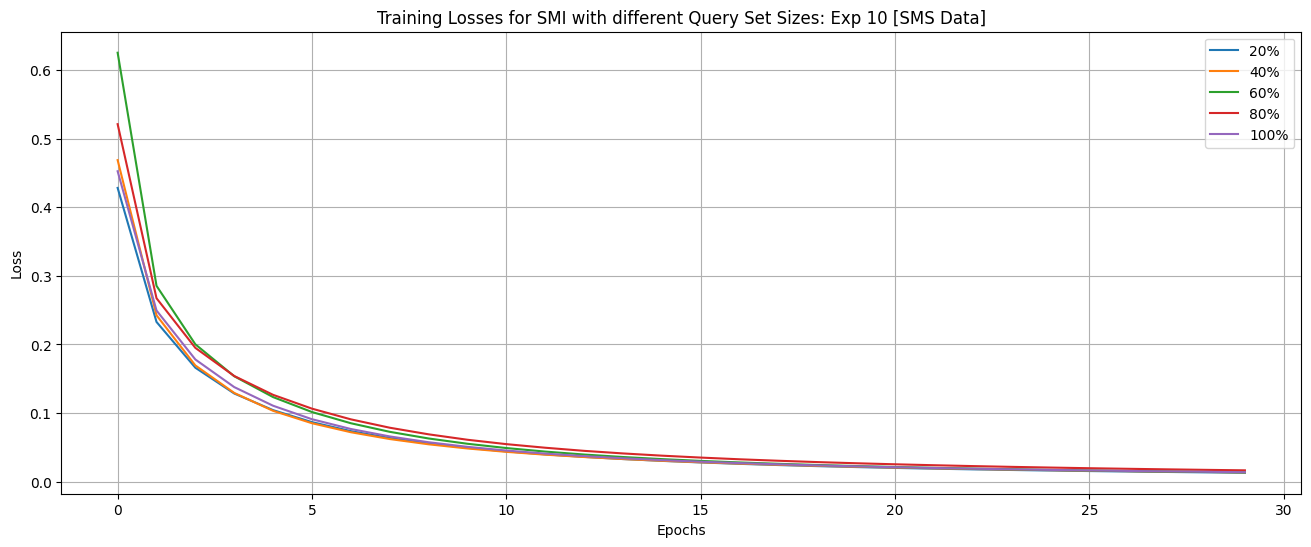

In [ ]:
plot_multiple_losses({
    '20%': losses_pc20, '40%': losses_pc40,
    '60%': losses_pc60, '80%': losses_pc80,
    '100%': losses_pc100
})

## Metric Compilation

In [ ]:
metric_list = [pc20_metrics, pc40_metrics, pc60_metrics,
               pc80_metrics, pc100_metrics]

In [ ]:
metrics_compiled = {k: {
    metric['name']: metric[k] for metric in metric_list
    } for k in metric_list[0] if (k!='name')}
metrics_compiled

{'tp': {'Size-20%': 258,
  'Size-40%': 215,
  'Size-60%': 181,
  'Size-80%': 126,
  'Size-100%': 229},
 'fp': {'Size-20%': 5,
  'Size-40%': 1,
  'Size-60%': 3,
  'Size-80%': 2,
  'Size-100%': 3},
 'fn': {'Size-20%': 218,
  'Size-40%': 261,
  'Size-60%': 295,
  'Size-80%': 350,
  'Size-100%': 247},
 'tn': {'Size-20%': 475,
  'Size-40%': 479,
  'Size-60%': 477,
  'Size-80%': 478,
  'Size-100%': 477},
 'acc': {'Size-20%': 0.7667364016736402,
  'Size-40%': 0.7259414225941423,
  'Size-60%': 0.6882845188284519,
  'Size-80%': 0.6317991631799164,
  'Size-100%': 0.7384937238493724},
 'f1': {'Size-20%': 0.6982408660351827,
  'Size-40%': 0.6213872832369942,
  'Size-60%': 0.5484848484848485,
  'Size-80%': 0.41721854304635764,
  'Size-100%': 0.6468926553672316},
 'ppv': {'Size-20%': 0.9809885931558935,
  'Size-40%': 0.9953703703703703,
  'Size-60%': 0.9836956521739131,
  'Size-80%': 0.984375,
  'Size-100%': 0.9870689655172413},
 'tpr': {'Size-20%': 0.542016806722689,
  'Size-40%': 0.451680672268907

In [ ]:
with open('logs.txt', 'a') as tf:
    tf.write('\n\nExp{}_metrics'.format(exp_num))
    tf.write(' = {')
    for k in metric_list[0]:
        if (k!='name'):
            tf.write("'{}': ".format(k))
            tf.write('{')
            for metric in metric_list[:-1]:
                tf.write("'{}': {}, ".format(metric['name'], round(metric[k], 5)))
            tf.write("'{}': {}".format(metric_list[-1]['name'], round(metric_list[-1][k], 5)))
            tf.write('}, ')

with open('logs.txt', 'r') as tf:
    contents = tf.read()
contents = contents[:-2]
with open('logs.txt', 'w') as tf:
    tf.write(contents)
    tf.write('}')


NOTE: Execute only till here for each experimental run. After each run, copy metrics generated in above output cell or output txt file and paste in the below cell for the respective experiment. After completing all 10 experiments, run below cells only by uncommenting to generate mean metrics and performance graphs.

## Overall Metric Stats

In [ ]:
def get_stats(values):
    return {'range': (min(values), max(values)), 'avg': round(sum(values)/len(values), 5), 'std_dev': round(stat.stdev(values), 5)}

In [ ]:
def end_of_exp():
    Exp1_metrics = {'tp': {'Size-20%': 47, 'Size-40%': 197, 'Size-60%': 259, 'Size-80%': 286, 'Size-100%': 235}, 'fp': {'Size-20%': 0, 'Size-40%': 3, 'Size-60%': 10, 'Size-80%': 11, 'Size-100%': 10}, 'fn': {'Size-20%': 429, 'Size-40%': 279, 'Size-60%': 217, 'Size-80%': 190, 'Size-100%': 241}, 'tn': {'Size-20%': 480, 'Size-40%': 477, 'Size-60%': 470, 'Size-80%': 469, 'Size-100%': 470}, 'acc': {'Size-20%': 0.55126, 'Size-40%': 0.70502, 'Size-60%': 0.76255, 'Size-80%': 0.78975, 'Size-100%': 0.73745}, 'f1': {'Size-20%': 0.17973, 'Size-40%': 0.58284, 'Size-60%': 0.6953, 'Size-80%': 0.73997, 'Size-100%': 0.65187}, 'ppv': {'Size-20%': 1.0, 'Size-40%': 0.985, 'Size-60%': 0.96283, 'Size-80%': 0.96296, 'Size-100%': 0.95918}, 'tpr': {'Size-20%': 0.09874, 'Size-40%': 0.41387, 'Size-60%': 0.54412, 'Size-80%': 0.60084, 'Size-100%': 0.4937}, 'fpr': {'Size-20%': 0.0, 'Size-40%': 0.00625, 'Size-60%': 0.02083, 'Size-80%': 0.02292, 'Size-100%': 0.02083}, 'fnr': {'Size-20%': 0.90126, 'Size-40%': 0.58613, 'Size-60%': 0.45588, 'Size-80%': 0.39916, 'Size-100%': 0.5063}, 'tnr': {'Size-20%': 1.0, 'Size-40%': 0.99375, 'Size-60%': 0.97917, 'Size-80%': 0.97708, 'Size-100%': 0.97917}, 'npv': {'Size-20%': 0.52805, 'Size-40%': 0.63095, 'Size-60%': 0.68413, 'Size-80%': 0.71168, 'Size-100%': 0.66104}, 'fdr': {'Size-20%': 0.0, 'Size-40%': 0.015, 'Size-60%': 0.03717, 'Size-80%': 0.03704, 'Size-100%': 0.04082}, 'mcc': {'Size-20%': 0.22834, 'Size-40%': 0.50107, 'Size-60%': 0.58184, 'Size-80%': 0.62442, 'Size-100%': 0.54156}}
    Exp2_metrics = {'tp': {'Size-20%': 162, 'Size-40%': 244, 'Size-60%': 226, 'Size-80%': 197, 'Size-100%': 232}, 'fp': {'Size-20%': 7, 'Size-40%': 10, 'Size-60%': 9, 'Size-80%': 5, 'Size-100%': 7}, 'fn': {'Size-20%': 314, 'Size-40%': 232, 'Size-60%': 250, 'Size-80%': 279, 'Size-100%': 244}, 'tn': {'Size-20%': 472, 'Size-40%': 469, 'Size-60%': 470, 'Size-80%': 474, 'Size-100%': 472}, 'acc': {'Size-20%': 0.66387, 'Size-40%': 0.7466, 'Size-60%': 0.7288, 'Size-80%': 0.70262, 'Size-100%': 0.73717}, 'f1': {'Size-20%': 0.50233, 'Size-40%': 0.66849, 'Size-60%': 0.63572, 'Size-80%': 0.58112, 'Size-100%': 0.64895}, 'ppv': {'Size-20%': 0.95858, 'Size-40%': 0.96063, 'Size-60%': 0.9617, 'Size-80%': 0.97525, 'Size-100%': 0.97071}, 'tpr': {'Size-20%': 0.34034, 'Size-40%': 0.51261, 'Size-60%': 0.47479, 'Size-80%': 0.41387, 'Size-100%': 0.48739}, 'fpr': {'Size-20%': 0.01461, 'Size-40%': 0.02088, 'Size-60%': 0.01879, 'Size-80%': 0.01044, 'Size-100%': 0.01461}, 'fnr': {'Size-20%': 0.65966, 'Size-40%': 0.48739, 'Size-60%': 0.52521, 'Size-80%': 0.58613, 'Size-100%': 0.51261}, 'tnr': {'Size-20%': 0.98539, 'Size-40%': 0.97912, 'Size-60%': 0.98121, 'Size-80%': 0.98956, 'Size-100%': 0.98539}, 'npv': {'Size-20%': 0.60051, 'Size-40%': 0.66904, 'Size-60%': 0.65278, 'Size-80%': 0.62948, 'Size-100%': 0.65922}, 'fdr': {'Size-20%': 0.04142, 'Size-40%': 0.03937, 'Size-60%': 0.0383, 'Size-80%': 0.02475, 'Size-100%': 0.02929}, 'mcc': {'Size-20%': 0.42674, 'Size-40%': 0.55644, 'Size-60%': 0.52934, 'Size-80%': 0.49393, 'Size-100%': 0.54573}}
    Exp3_metrics = {'tp': {'Size-20%': 116, 'Size-40%': 173, 'Size-60%': 285, 'Size-80%': 193, 'Size-100%': 262}, 'fp': {'Size-20%': 0, 'Size-40%': 1, 'Size-60%': 4, 'Size-80%': 2, 'Size-100%': 5}, 'fn': {'Size-20%': 360, 'Size-40%': 303, 'Size-60%': 191, 'Size-80%': 283, 'Size-100%': 214}, 'tn': {'Size-20%': 479, 'Size-40%': 478, 'Size-60%': 475, 'Size-80%': 477, 'Size-100%': 474}, 'acc': {'Size-20%': 0.62304, 'Size-40%': 0.68168, 'Size-60%': 0.79581, 'Size-80%': 0.70157, 'Size-100%': 0.77068}, 'f1': {'Size-20%': 0.39189, 'Size-40%': 0.53231, 'Size-60%': 0.7451, 'Size-80%': 0.57526, 'Size-100%': 0.70525}, 'ppv': {'Size-20%': 1.0, 'Size-40%': 0.99425, 'Size-60%': 0.98616, 'Size-80%': 0.98974, 'Size-100%': 0.98127}, 'tpr': {'Size-20%': 0.2437, 'Size-40%': 0.36345, 'Size-60%': 0.59874, 'Size-80%': 0.40546, 'Size-100%': 0.55042}, 'fpr': {'Size-20%': 0.0, 'Size-40%': 0.00209, 'Size-60%': 0.00835, 'Size-80%': 0.00418, 'Size-100%': 0.01044}, 'fnr': {'Size-20%': 0.7563, 'Size-40%': 0.63655, 'Size-60%': 0.40126, 'Size-80%': 0.59454, 'Size-100%': 0.44958}, 'tnr': {'Size-20%': 1.0, 'Size-40%': 0.99791, 'Size-60%': 0.99165, 'Size-80%': 0.99582, 'Size-100%': 0.98956}, 'npv': {'Size-20%': 0.57092, 'Size-40%': 0.61204, 'Size-60%': 0.71321, 'Size-80%': 0.62763, 'Size-100%': 0.68895}, 'fdr': {'Size-20%': 0.0, 'Size-40%': 0.00575, 'Size-60%': 0.01384, 'Size-80%': 0.01026, 'Size-100%': 0.01873}, 'mcc': {'Size-20%': 0.373, 'Size-40%': 0.46807, 'Size-60%': 0.64257, 'Size-80%': 0.49774, 'Size-100%': 0.60159}}
    Exp4_metrics = {'tp': {'Size-20%': 16, 'Size-40%': 227, 'Size-60%': 196, 'Size-80%': 223, 'Size-100%': 141}, 'fp': {'Size-20%': 0, 'Size-40%': 6, 'Size-60%': 2, 'Size-80%': 6, 'Size-100%': 0}, 'fn': {'Size-20%': 460, 'Size-40%': 249, 'Size-60%': 280, 'Size-80%': 253, 'Size-100%': 335}, 'tn': {'Size-20%': 479, 'Size-40%': 473, 'Size-60%': 477, 'Size-80%': 473, 'Size-100%': 479}, 'acc': {'Size-20%': 0.51832, 'Size-40%': 0.73298, 'Size-60%': 0.70471, 'Size-80%': 0.7288, 'Size-100%': 0.64921}, 'f1': {'Size-20%': 0.06504, 'Size-40%': 0.64034, 'Size-60%': 0.5816, 'Size-80%': 0.63262, 'Size-100%': 0.45705}, 'ppv': {'Size-20%': 1.0, 'Size-40%': 0.97425, 'Size-60%': 0.9899, 'Size-80%': 0.9738, 'Size-100%': 1.0}, 'tpr': {'Size-20%': 0.03361, 'Size-40%': 0.47689, 'Size-60%': 0.41176, 'Size-80%': 0.46849, 'Size-100%': 0.29622}, 'fpr': {'Size-20%': 0.0, 'Size-40%': 0.01253, 'Size-60%': 0.00418, 'Size-80%': 0.01253, 'Size-100%': 0.0}, 'fnr': {'Size-20%': 0.96639, 'Size-40%': 0.52311, 'Size-60%': 0.58824, 'Size-80%': 0.53151, 'Size-100%': 0.70378}, 'tnr': {'Size-20%': 1.0, 'Size-40%': 0.98747, 'Size-60%': 0.99582, 'Size-80%': 0.98747, 'Size-100%': 1.0}, 'npv': {'Size-20%': 0.51012, 'Size-40%': 0.65512, 'Size-60%': 0.63012, 'Size-80%': 0.65152, 'Size-100%': 0.58845}, 'fdr': {'Size-20%': 0.0, 'Size-40%': 0.02575, 'Size-60%': 0.0101, 'Size-80%': 0.0262, 'Size-100%': 0.0}, 'mcc': {'Size-20%': 0.13095, 'Size-40%': 0.54061, 'Size-60%': 0.50271, 'Size-80%': 0.53397, 'Size-100%': 0.4175}}
    Exp5_metrics = {'tp': {'Size-20%': 148, 'Size-40%': 161, 'Size-60%': 134, 'Size-80%': 159, 'Size-100%': 185}, 'fp': {'Size-20%': 1, 'Size-40%': 1, 'Size-60%': 1, 'Size-80%': 2, 'Size-100%': 1}, 'fn': {'Size-20%': 328, 'Size-40%': 315, 'Size-60%': 342, 'Size-80%': 317, 'Size-100%': 291}, 'tn': {'Size-20%': 479, 'Size-40%': 479, 'Size-60%': 479, 'Size-80%': 478, 'Size-100%': 479}, 'acc': {'Size-20%': 0.65586, 'Size-40%': 0.66946, 'Size-60%': 0.64121, 'Size-80%': 0.66632, 'Size-100%': 0.69456}, 'f1': {'Size-20%': 0.4736, 'Size-40%': 0.5047, 'Size-60%': 0.43863, 'Size-80%': 0.49922, 'Size-100%': 0.55891}, 'ppv': {'Size-20%': 0.99329, 'Size-40%': 0.99383, 'Size-60%': 0.99259, 'Size-80%': 0.98758, 'Size-100%': 0.99462}, 'tpr': {'Size-20%': 0.31092, 'Size-40%': 0.33824, 'Size-60%': 0.28151, 'Size-80%': 0.33403, 'Size-100%': 0.38866}, 'fpr': {'Size-20%': 0.00208, 'Size-40%': 0.00208, 'Size-60%': 0.00208, 'Size-80%': 0.00417, 'Size-100%': 0.00208}, 'fnr': {'Size-20%': 0.68908, 'Size-40%': 0.66176, 'Size-60%': 0.71849, 'Size-80%': 0.66597, 'Size-100%': 0.61134}, 'tnr': {'Size-20%': 0.99792, 'Size-40%': 0.99792, 'Size-60%': 0.99792, 'Size-80%': 0.99583, 'Size-100%': 0.99792}, 'npv': {'Size-20%': 0.59356, 'Size-40%': 0.60327, 'Size-60%': 0.58343, 'Size-80%': 0.60126, 'Size-100%': 0.62208}, 'fdr': {'Size-20%': 0.00671, 'Size-40%': 0.00617, 'Size-60%': 0.00741, 'Size-80%': 0.01242, 'Size-100%': 0.00538}, 'mcc': {'Size-20%': 0.42573, 'Size-40%': 0.44801, 'Size-60%': 0.4012, 'Size-80%': 0.44072, 'Size-100%': 0.48826}}
    Exp6_metrics = {'tp': {'Size-20%': 85, 'Size-40%': 107, 'Size-60%': 234, 'Size-80%': 220, 'Size-100%': 278}, 'fp': {'Size-20%': 0, 'Size-40%': 0, 'Size-60%': 4, 'Size-80%': 1, 'Size-100%': 7}, 'fn': {'Size-20%': 391, 'Size-40%': 369, 'Size-60%': 242, 'Size-80%': 256, 'Size-100%': 198}, 'tn': {'Size-20%': 479, 'Size-40%': 479, 'Size-60%': 475, 'Size-80%': 478, 'Size-100%': 472}, 'acc': {'Size-20%': 0.59058, 'Size-40%': 0.61361, 'Size-60%': 0.74241, 'Size-80%': 0.73089, 'Size-100%': 0.78534}, 'f1': {'Size-20%': 0.30303, 'Size-40%': 0.36707, 'Size-60%': 0.65546, 'Size-80%': 0.63128, 'Size-100%': 0.73062}, 'ppv': {'Size-20%': 1.0, 'Size-40%': 1.0, 'Size-60%': 0.98319, 'Size-80%': 0.99548, 'Size-100%': 0.97544}, 'tpr': {'Size-20%': 0.17857, 'Size-40%': 0.22479, 'Size-60%': 0.4916, 'Size-80%': 0.46218, 'Size-100%': 0.58403}, 'fpr': {'Size-20%': 0.0, 'Size-40%': 0.0, 'Size-60%': 0.00835, 'Size-80%': 0.00209, 'Size-100%': 0.01461}, 'fnr': {'Size-20%': 0.82143, 'Size-40%': 0.77521, 'Size-60%': 0.5084, 'Size-80%': 0.53782, 'Size-100%': 0.41597}, 'tnr': {'Size-20%': 1.0, 'Size-40%': 1.0, 'Size-60%': 0.99165, 'Size-80%': 0.99791, 'Size-100%': 0.98539}, 'npv': {'Size-20%': 0.55057, 'Size-40%': 0.56486, 'Size-60%': 0.66248, 'Size-80%': 0.65123, 'Size-100%': 0.70448}, 'fdr': {'Size-20%': 0.0, 'Size-40%': 0.0, 'Size-60%': 0.01681, 'Size-80%': 0.00452, 'Size-100%': 0.02456}, 'mcc': {'Size-20%': 0.31356, 'Size-40%': 0.35633, 'Size-60%': 0.55859, 'Size-80%': 0.54548, 'Size-100%': 0.62222}}
    Exp7_metrics = {'tp': {'Size-20%': 198, 'Size-40%': 156, 'Size-60%': 326, 'Size-80%': 314, 'Size-100%': 202}, 'fp': {'Size-20%': 3, 'Size-40%': 0, 'Size-60%': 5, 'Size-80%': 14, 'Size-100%': 1}, 'fn': {'Size-20%': 278, 'Size-40%': 320, 'Size-60%': 150, 'Size-80%': 162, 'Size-100%': 274}, 'tn': {'Size-20%': 477, 'Size-40%': 480, 'Size-60%': 475, 'Size-80%': 466, 'Size-100%': 479}, 'acc': {'Size-20%': 0.70607, 'Size-40%': 0.66527, 'Size-60%': 0.83787, 'Size-80%': 0.8159, 'Size-100%': 0.71234}, 'f1': {'Size-20%': 0.58493, 'Size-40%': 0.49367, 'Size-60%': 0.80793, 'Size-80%': 0.78109, 'Size-100%': 0.59499}, 'ppv': {'Size-20%': 0.98507, 'Size-40%': 1.0, 'Size-60%': 0.98489, 'Size-80%': 0.95732, 'Size-100%': 0.99507}, 'tpr': {'Size-20%': 0.41597, 'Size-40%': 0.32773, 'Size-60%': 0.68487, 'Size-80%': 0.65966, 'Size-100%': 0.42437}, 'fpr': {'Size-20%': 0.00625, 'Size-40%': 0.0, 'Size-60%': 0.01042, 'Size-80%': 0.02917, 'Size-100%': 0.00208}, 'fnr': {'Size-20%': 0.58403, 'Size-40%': 0.67227, 'Size-60%': 0.31513, 'Size-80%': 0.34034, 'Size-100%': 0.57563}, 'tnr': {'Size-20%': 0.99375, 'Size-40%': 1.0, 'Size-60%': 0.98958, 'Size-80%': 0.97083, 'Size-100%': 0.99792}, 'npv': {'Size-20%': 0.63179, 'Size-40%': 0.6, 'Size-60%': 0.76, 'Size-80%': 0.74204, 'Size-100%': 0.63612}, 'fdr': {'Size-20%': 0.01493, 'Size-40%': 0.0, 'Size-60%': 0.01511, 'Size-80%': 0.04268, 'Size-100%': 0.00493}, 'mcc': {'Size-20%': 0.50273, 'Size-40%': 0.44344, 'Size-60%': 0.7088, 'Size-80%': 0.66403, 'Size-100%': 0.51628}}
    Exp8_metrics = {'tp': {'Size-20%': 156, 'Size-40%': 188, 'Size-60%': 59, 'Size-80%': 17, 'Size-100%': 187}, 'fp': {'Size-20%': 0, 'Size-40%': 0, 'Size-60%': 0, 'Size-80%': 0, 'Size-100%': 1}, 'fn': {'Size-20%': 320, 'Size-40%': 288, 'Size-60%': 417, 'Size-80%': 459, 'Size-100%': 289}, 'tn': {'Size-20%': 479, 'Size-40%': 479, 'Size-60%': 479, 'Size-80%': 479, 'Size-100%': 478}, 'acc': {'Size-20%': 0.66492, 'Size-40%': 0.69843, 'Size-60%': 0.56335, 'Size-80%': 0.51937, 'Size-100%': 0.69634}, 'f1': {'Size-20%': 0.49367, 'Size-40%': 0.56627, 'Size-60%': 0.22056, 'Size-80%': 0.06897, 'Size-100%': 0.56325}, 'ppv': {'Size-20%': 1.0, 'Size-40%': 1.0, 'Size-60%': 1.0, 'Size-80%': 1.0, 'Size-100%': 0.99468}, 'tpr': {'Size-20%': 0.32773, 'Size-40%': 0.39496, 'Size-60%': 0.12395, 'Size-80%': 0.03571, 'Size-100%': 0.39286}, 'fpr': {'Size-20%': 0.0, 'Size-40%': 0.0, 'Size-60%': 0.0, 'Size-80%': 0.0, 'Size-100%': 0.00209}, 'fnr': {'Size-20%': 0.67227, 'Size-40%': 0.60504, 'Size-60%': 0.87605, 'Size-80%': 0.96429, 'Size-100%': 0.60714}, 'tnr': {'Size-20%': 1.0, 'Size-40%': 1.0, 'Size-60%': 1.0, 'Size-80%': 1.0, 'Size-100%': 0.99791}, 'npv': {'Size-20%': 0.5995, 'Size-40%': 0.62451, 'Size-60%': 0.5346, 'Size-80%': 0.51066, 'Size-100%': 0.62321}, 'fdr': {'Size-20%': 0.0, 'Size-40%': 0.0, 'Size-60%': 0.0, 'Size-80%': 0.0, 'Size-100%': 0.00532}, 'mcc': {'Size-20%': 0.44325, 'Size-40%': 0.49664, 'Size-60%': 0.25742, 'Size-80%': 0.13505, 'Size-100%': 0.49138}}
    Exp9_metrics = {'tp': {'Size-20%': 141, 'Size-40%': 132, 'Size-60%': 117, 'Size-80%': 236, 'Size-100%': 292}, 'fp': {'Size-20%': 1, 'Size-40%': 2, 'Size-60%': 3, 'Size-80%': 4, 'Size-100%': 11}, 'fn': {'Size-20%': 335, 'Size-40%': 344, 'Size-60%': 359, 'Size-80%': 240, 'Size-100%': 184}, 'tn': {'Size-20%': 478, 'Size-40%': 477, 'Size-60%': 476, 'Size-80%': 475, 'Size-100%': 468}, 'acc': {'Size-20%': 0.64817, 'Size-40%': 0.6377, 'Size-60%': 0.62094, 'Size-80%': 0.7445, 'Size-100%': 0.79581}, 'f1': {'Size-20%': 0.45631, 'Size-40%': 0.43279, 'Size-60%': 0.39262, 'Size-80%': 0.65922, 'Size-100%': 0.74968}, 'ppv': {'Size-20%': 0.99296, 'Size-40%': 0.98507, 'Size-60%': 0.975, 'Size-80%': 0.98333, 'Size-100%': 0.9637}, 'tpr': {'Size-20%': 0.29622, 'Size-40%': 0.27731, 'Size-60%': 0.2458, 'Size-80%': 0.4958, 'Size-100%': 0.61345}, 'fpr': {'Size-20%': 0.00209, 'Size-40%': 0.00418, 'Size-60%': 0.00626, 'Size-80%': 0.00835, 'Size-100%': 0.02296}, 'fnr': {'Size-20%': 0.70378, 'Size-40%': 0.72269, 'Size-60%': 0.7542, 'Size-80%': 0.5042, 'Size-100%': 0.38655}, 'tnr': {'Size-20%': 0.99791, 'Size-40%': 0.99582, 'Size-60%': 0.99374, 'Size-80%': 0.99165, 'Size-100%': 0.97704}, 'npv': {'Size-20%': 0.58795, 'Size-40%': 0.581, 'Size-60%': 0.57006, 'Size-80%': 0.66434, 'Size-100%': 0.71779}, 'fdr': {'Size-20%': 0.00704, 'Size-40%': 0.01493, 'Size-60%': 0.025, 'Size-80%': 0.01667, 'Size-100%': 0.0363}, 'mcc': {'Size-20%': 0.41335, 'Size-40%': 0.39321, 'Size-60%': 0.36133, 'Size-80%': 0.56188, 'Size-100%': 0.63435}}
    Exp10_metrics = {'tp': {'Size-20%': 258, 'Size-40%': 215, 'Size-60%': 181, 'Size-80%': 126, 'Size-100%': 229}, 'fp': {'Size-20%': 5, 'Size-40%': 1, 'Size-60%': 3, 'Size-80%': 2, 'Size-100%': 3}, 'fn': {'Size-20%': 218, 'Size-40%': 261, 'Size-60%': 295, 'Size-80%': 350, 'Size-100%': 247}, 'tn': {'Size-20%': 475, 'Size-40%': 479, 'Size-60%': 477, 'Size-80%': 478, 'Size-100%': 477}, 'acc': {'Size-20%': 0.76674, 'Size-40%': 0.72594, 'Size-60%': 0.68828, 'Size-80%': 0.6318, 'Size-100%': 0.73849}, 'f1': {'Size-20%': 0.69824, 'Size-40%': 0.62139, 'Size-60%': 0.54848, 'Size-80%': 0.41722, 'Size-100%': 0.64689}, 'ppv': {'Size-20%': 0.98099, 'Size-40%': 0.99537, 'Size-60%': 0.9837, 'Size-80%': 0.98438, 'Size-100%': 0.98707}, 'tpr': {'Size-20%': 0.54202, 'Size-40%': 0.45168, 'Size-60%': 0.38025, 'Size-80%': 0.26471, 'Size-100%': 0.48109}, 'fpr': {'Size-20%': 0.01042, 'Size-40%': 0.00208, 'Size-60%': 0.00625, 'Size-80%': 0.00417, 'Size-100%': 0.00625}, 'fnr': {'Size-20%': 0.45798, 'Size-40%': 0.54832, 'Size-60%': 0.61975, 'Size-80%': 0.73529, 'Size-100%': 0.51891}, 'tnr': {'Size-20%': 0.98958, 'Size-40%': 0.99792, 'Size-60%': 0.99375, 'Size-80%': 0.99583, 'Size-100%': 0.99375}, 'npv': {'Size-20%': 0.68543, 'Size-40%': 0.6473, 'Size-60%': 0.61788, 'Size-80%': 0.57729, 'Size-100%': 0.65884}, 'fdr': {'Size-20%': 0.01901, 'Size-40%': 0.00463, 'Size-60%': 0.0163, 'Size-80%': 0.01562, 'Size-100%': 0.01293}, 'mcc': {'Size-20%': 0.5952, 'Size-40%': 0.53753, 'Size-60%': 0.47433, 'Size-80%': 0.38254, 'Size-100%': 0.55381}}
    Metric_stats = {k: {
        metric: get_stats([exp[k][metric] for exp in [
            Exp1_metrics, Exp2_metrics, Exp3_metrics, Exp4_metrics, Exp5_metrics,
            Exp6_metrics, Exp7_metrics, Exp8_metrics, Exp9_metrics, Exp10_metrics
            ]]) for metric in Exp1_metrics[k]} for k in Exp1_metrics}
    return Metric_stats

In [ ]:
Metric_stats = end_of_exp()
Metric_stats

{'tp': {'Size-20%': {'range': (16, 258), 'avg': 132.7, 'std_dev': 70.85674},
  'Size-40%': {'range': (107, 244), 'avg': 180.0, 'std_dev': 42.82004},
  'Size-60%': {'range': (59, 326), 'avg': 201.7, 'std_dev': 81.57348},
  'Size-80%': {'range': (17, 314), 'avg': 197.1, 'std_dev': 83.82316},
  'Size-100%': {'range': (141, 292), 'avg': 224.3, 'std_dev': 46.49504}},
 'fp': {'Size-20%': {'range': (0, 7), 'avg': 1.7, 'std_dev': 2.49666},
  'Size-40%': {'range': (0, 10), 'avg': 2.4, 'std_dev': 3.23866},
  'Size-60%': {'range': (0, 10), 'avg': 4.1, 'std_dev': 3.21282},
  'Size-80%': {'range': (0, 14), 'avg': 4.7, 'std_dev': 4.54728},
  'Size-100%': {'range': (0, 11), 'avg': 4.6, 'std_dev': 4.00555}},
 'fn': {'Size-20%': {'range': (218, 460), 'avg': 343.3, 'std_dev': 70.85674},
  'Size-40%': {'range': (232, 369), 'avg': 296.0, 'std_dev': 42.82004},
  'Size-60%': {'range': (150, 417), 'avg': 274.3, 'std_dev': 81.57348},
  'Size-80%': {'range': (162, 459), 'avg': 278.9, 'std_dev': 83.82316},
  'S

## Performance Graphs - Means and Ranges

In [ ]:
def graph_metric(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    min_values = [data[strategy]['range'][0] for strategy in strategies]
    max_values = [data[strategy]['range'][1] for strategy in strategies]
    errors = [np.subtract(averages, min_values), np.subtract(max_values, averages)]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    # using tuple unpacking to grab fig and axes
    fig, ax = plt.subplots(figsize=(16, 6))

    # plotting the bar plot
    plt.plot(strategies, averages, 'o-', color='black', label=strategies)
    # ax.bar(strategies, averages, alpha = 0)

    # Plot error bars
    for i, (strategy, avg) in enumerate(zip(strategies, averages)):
        y_err_lower = errors[0][i]
        y_err_upper = errors[1][i]
        y_err = [[y_err_lower], [y_err_upper]]
        ax.errorbar(strategy, avg, yerr=y_err, fmt='o', lw=2, capsize=4, capthick=2, color=colors[i])

    # Set plot details
    plt.title('Effect of different query set sizes on: {} [SMS Data]'.format(metric_dict[metric]))
    plt.xlabel('Query Set Size')
    plt.ylabel('Average (with range)')
    plt.show()

### Accuracy Graph

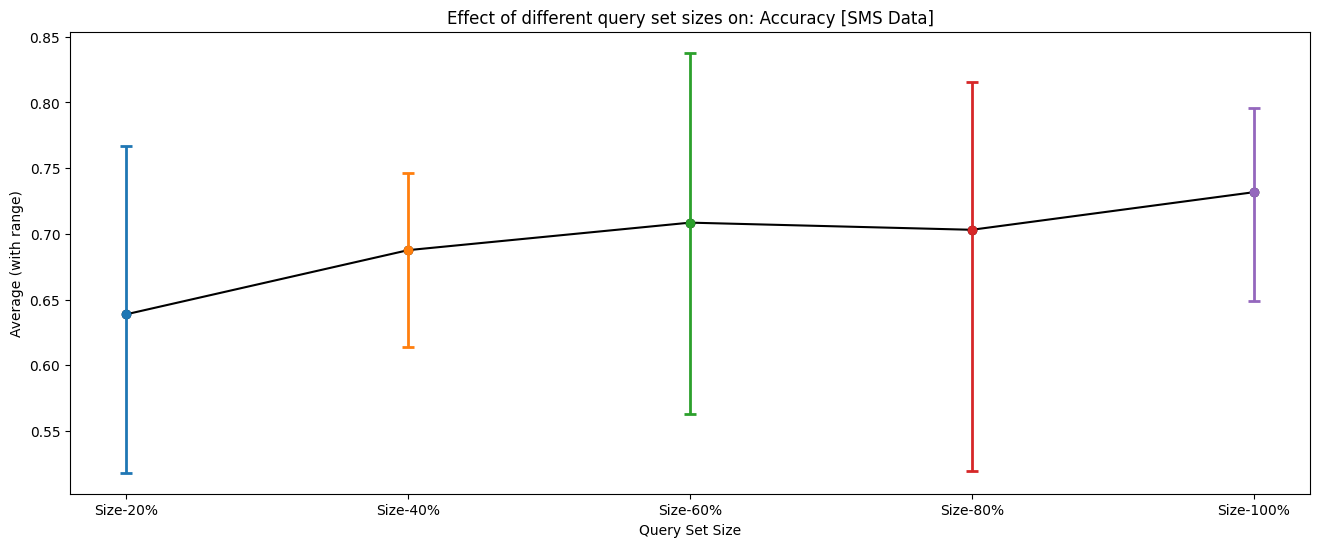

In [ ]:
graph_metric('acc')

### F-1 Score Graph

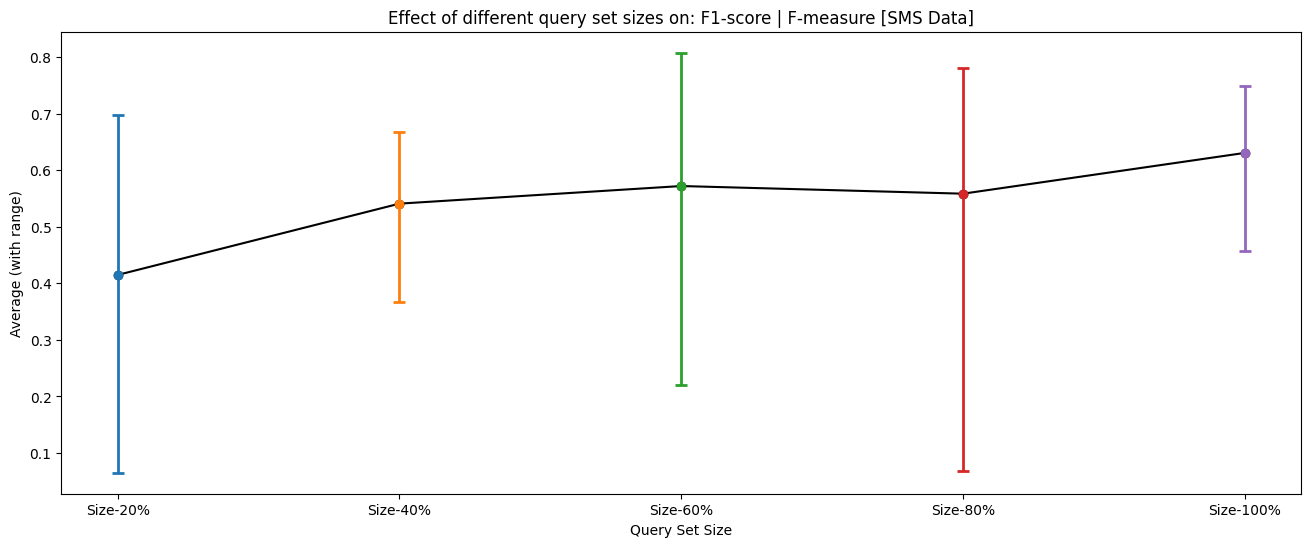

In [ ]:
graph_metric('f1')

### Precision Graphs

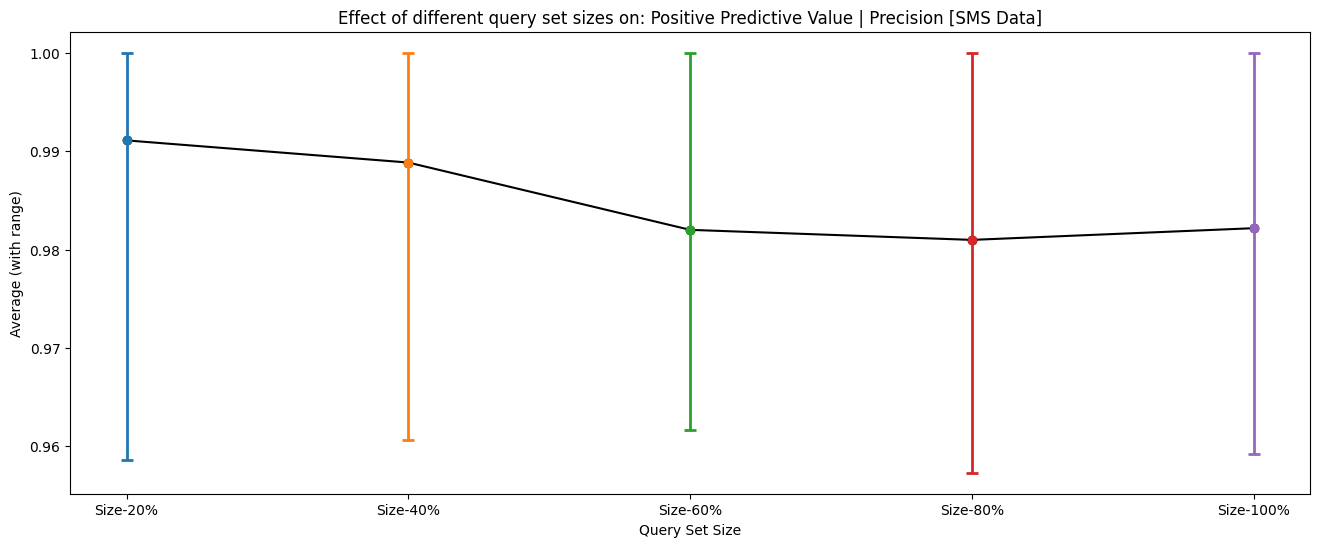

In [ ]:
graph_metric('ppv')

### Recall Graphs

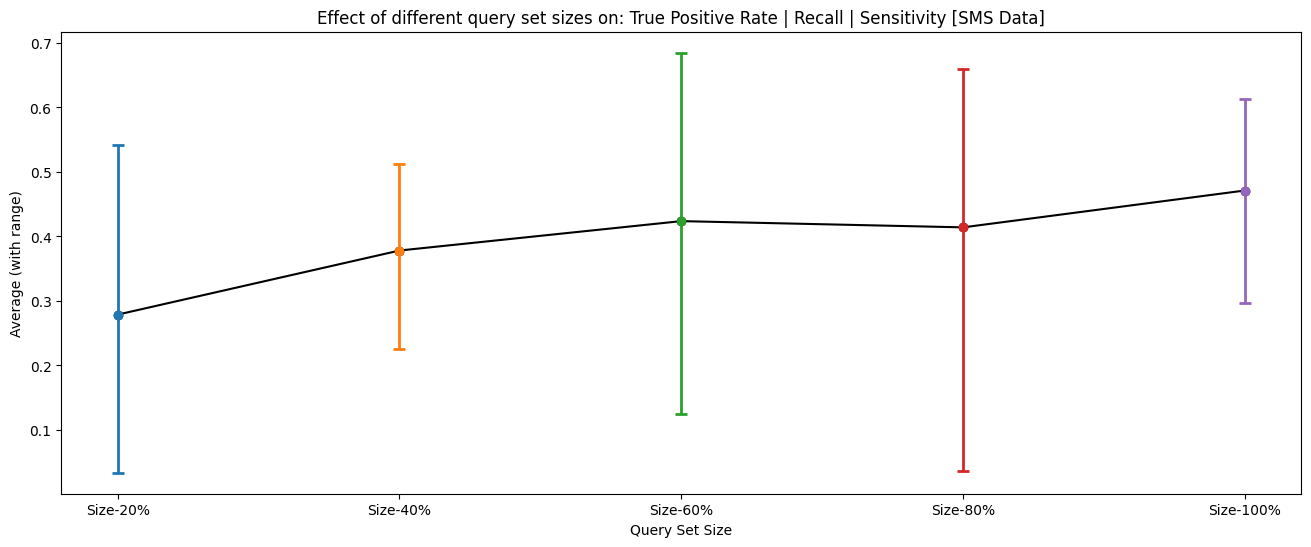

In [ ]:
graph_metric('tpr')

### Matthews Correlation Coefficient Graphs

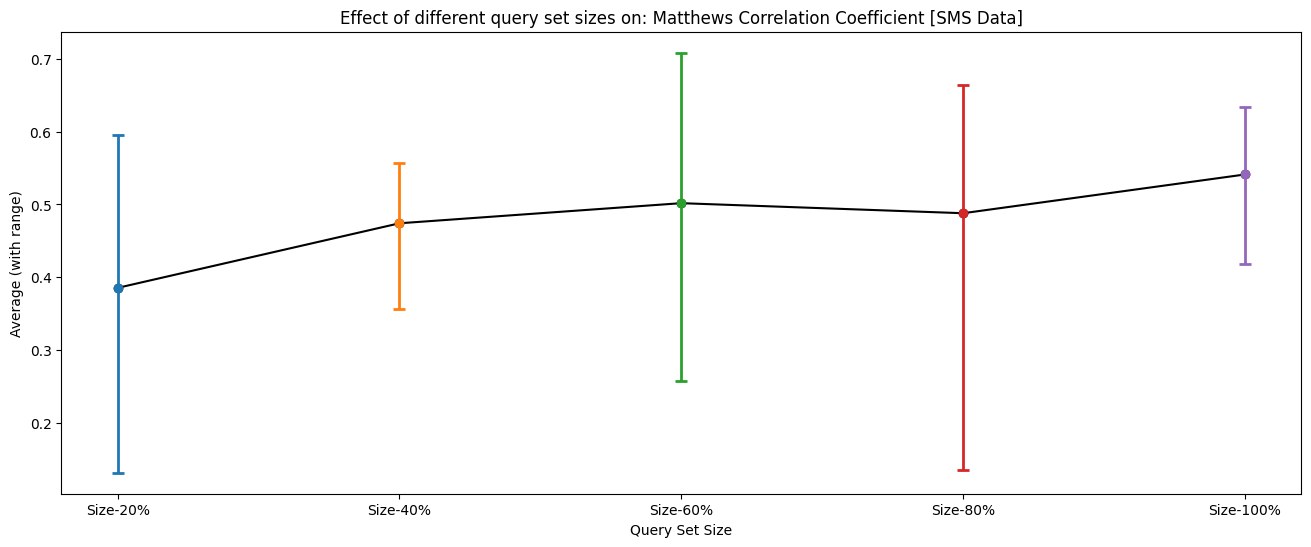

In [ ]:
graph_metric('mcc')

## Performance Graphs - Metric Variations

In [ ]:
def graph_variance(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    std_devs = [data[strategy]['std_dev']/2 for strategy in strategies]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    plt.figure(figsize=(16, 6))
    plt.bar(strategies, averages, yerr=std_devs, alpha = 0.3, capsize=5, color=colors)
    plt.xlabel('Query Set Sizes')
    plt.ylabel('Average (with standard deviation)')
    plt.title('Variation caused by different query set sizes on: {} [SMS Data]'.format(metric_dict[metric]))
    plt.show()

### Accuracy Variation

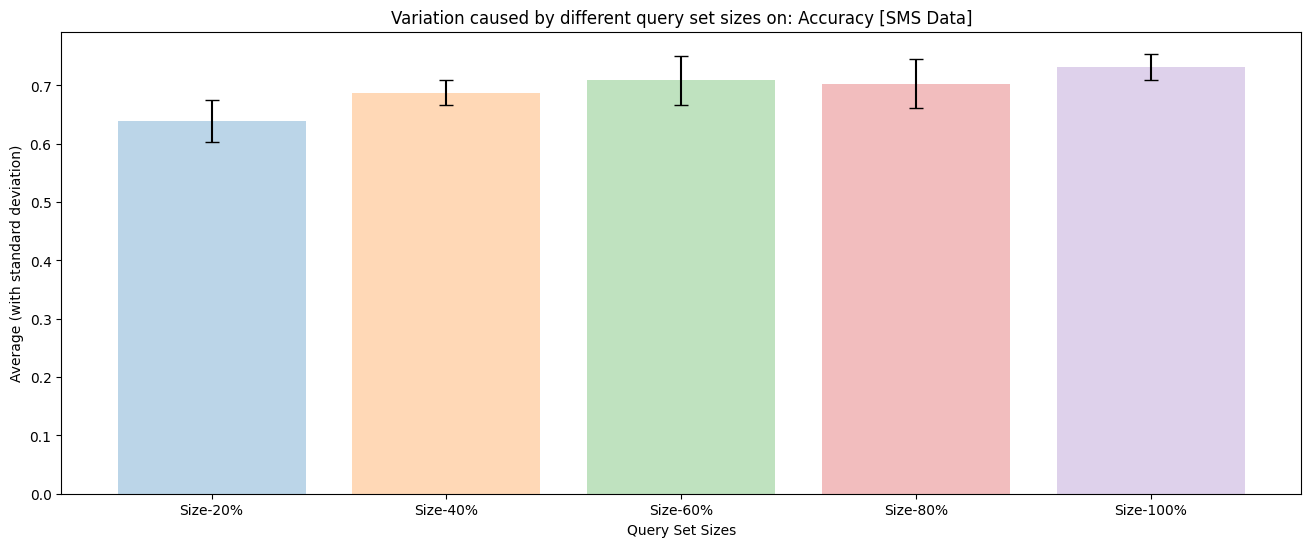

In [ ]:
graph_variance('acc')

### F1-Score Variation

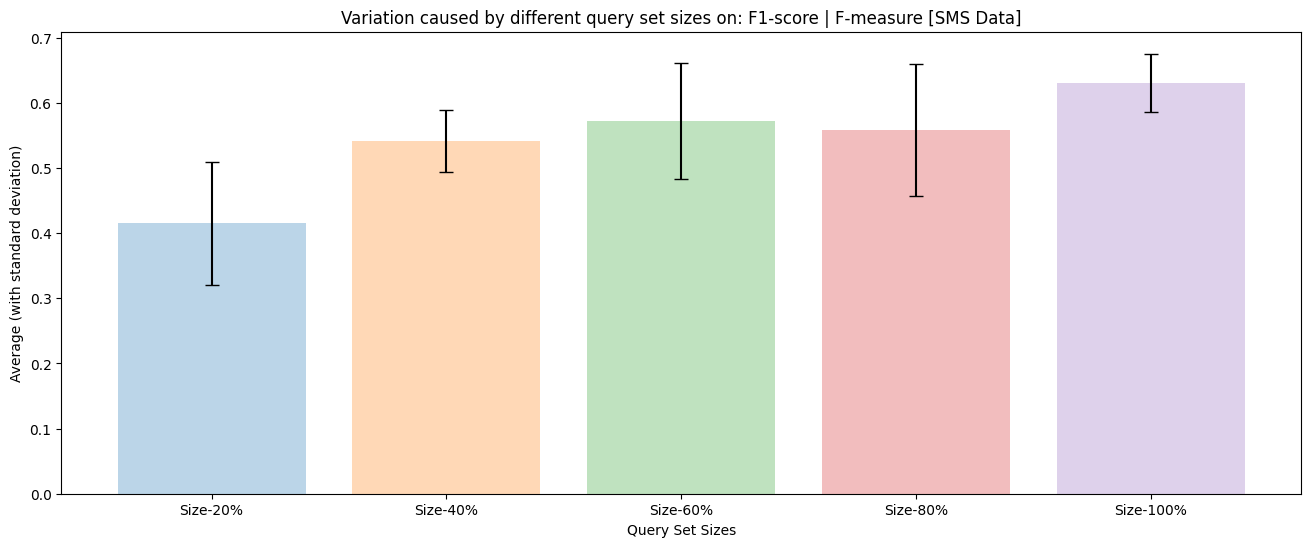

In [ ]:
graph_variance('f1')

### Precision Variation

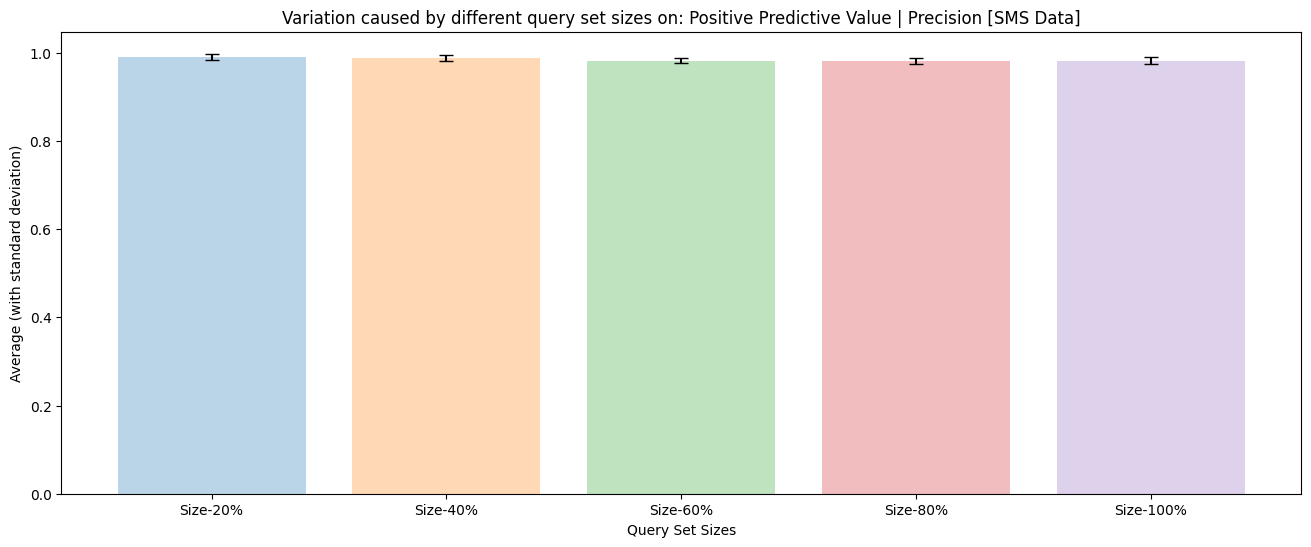

In [ ]:
graph_variance('ppv')

### Recall Variation

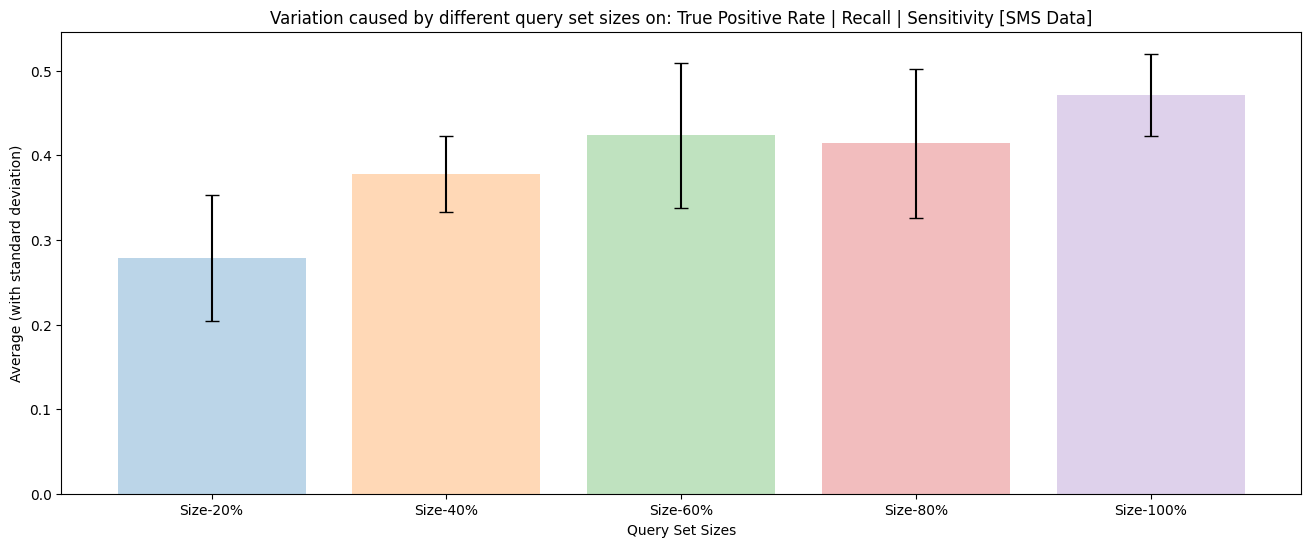

In [ ]:
graph_variance('tpr')

### Matthews Correlation Coefficient Variation

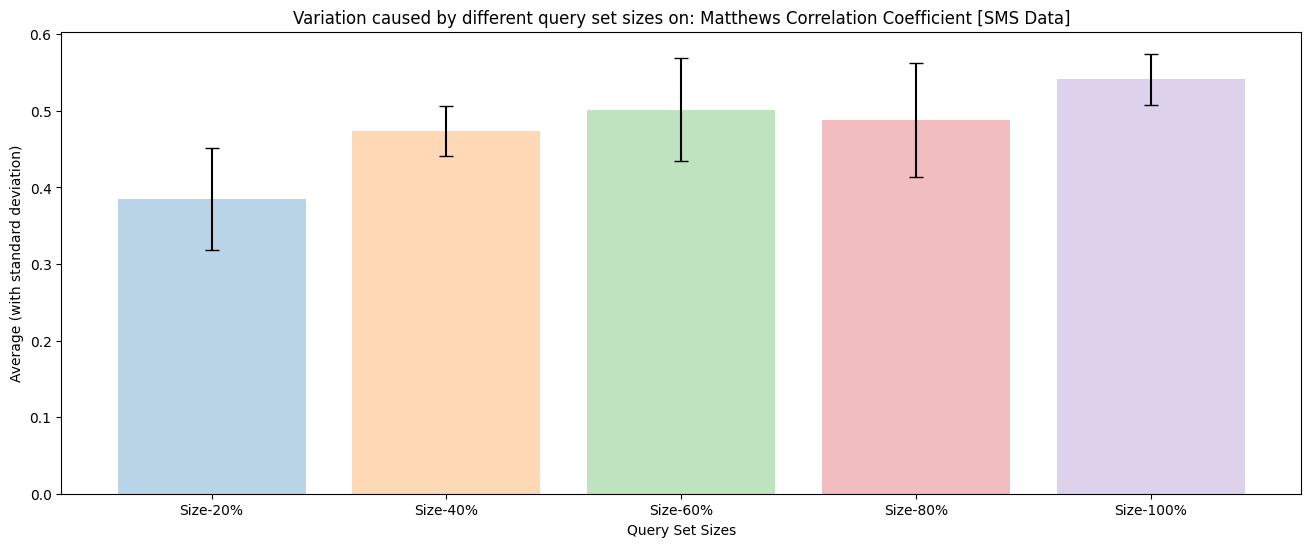

In [ ]:
graph_variance('mcc')